Setup

Import libraries and set figure parameters and paths

In [1]:
import os

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
import sys
sys.path.append('/home/yq238/.local/lib/python3.11/site-packages')

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import scarches as sca
import anndata as ad
from scipy import sparse
import gdown
import gzip
import shutil
import urllib.request

 captum (see https://github.com/pytorch/captum).


Set scanpy figure parameters:

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

Set paths:

In [5]:
ref_model_dir_prefix = "."  # directory in which to store the reference model directory
surgery_model_dir_prefix = (
    "."  # directory in which to store the surgery model directory
)
path_reference_emb = (
    "./HLCA_emb_and_metadata.h5ad"  # path to reference embedding to be created
)
path_query_data = "./HLCA_query.h5ad"  # input test query data
# don't change the following paths:
ref_model_dir = os.path.join(
    ref_model_dir_prefix, "HLCA_reference_model"
)  # don't change this
surgery_model_dir = os.path.join(
    surgery_model_dir_prefix, "surgery_model"
)  # don't change this

Download reference data and reference model:

We will start with downloading the needed model and data. First, let's download the reference model, on which we will perform surgery. The HLCA reference model can be found on Zenodo, and we'll download it below:

In [6]:
url = "https://zenodo.org/record/7599104/files/HLCA_reference_model.zip"
output = "HLCA_reference_model.zip"
gdown.download(url, output, quiet=False)
shutil.unpack_archive("HLCA_reference_model.zip", extract_dir=ref_model_dir_prefix)
os.remove(output)

Downloading...
From: https://zenodo.org/record/7599104/files/HLCA_reference_model.zip
To: /gpfs/gibbs/project/augert/yq238/scRNA_seq/HTAN3/04normal_subtype/HLCA_reference_model.zip
100%|██████████| 10.6M/10.6M [03:07<00:00, 56.9kB/s]


We will furthermore download the reference itself. As scArches allows the mapping of query data onto an existing reference embedding, we will only need to download the embedding of the HLCA reference. That saves a lot of time and memory compared to downloading the full count matrix. It might take a while to download this embedding, it's 2.3Gb in size.

In [7]:
url = "https://zenodo.org/record/7599104/files/HLCA_full_v1.1_emb.h5ad"
output = path_reference_emb
#gdown.download(url, output, quiet=False)

Let's load our downloaded reference embedding:

In [8]:
adata_ref = sc.read_h5ad(path_reference_emb)
adata_ref.shape

(2282447, 30)

In [9]:
adata_ref

AnnData object with n_obs × n_vars = 2282447 × 30
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 'ti

In [10]:
# subset
adata_ref = adata_ref[(adata_ref.obs['ann_level_1'] == "Epithelial") & 
                          (adata_ref.obs['core_or_extension'] == "core")].copy()
adata_ref.shape

(282065, 30)

In [11]:
adata_ref

AnnData object with n_obs × n_vars = 282065 × 30
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 'tis

This embedding includes both the HLCA core (healthy reference, integrated with scANVI) and the HLCA extension (core + lung disease datasets mapped with scArches). We will subset to the HLCA core here, as this is what the reference model was trained on.

In [12]:
# subset
# adata_ref = adata_ref[adata_ref.obs.core_or_extension == "core", :].copy()
# remove all obs variables that have no entries anymore (i.e. obs columns that were only relevant for the HLCA extension)
cols_to_drop = [
    col for col in adata_ref.obs.columns if adata_ref.obs[col].isnull().all()
]
adata_ref.obs.drop(columns=cols_to_drop, inplace=True)

In [13]:
adata_ref

AnnData object with n_obs × n_vars = 282065 × 30
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 'tis

Seagrass genomes reveal ancient polyploidy and adaptations to the marine environment

Finally, we need to have query data which we want to map to the reference.

In [14]:
adata_query_unprep = sc.read_h5ad('./sce_obj.h5ad')

In [15]:
adata_query_unprep

AnnData object with n_obs × n_vars = 22564 × 21926
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'mnn_clusters', 'seurat_clusters', 'coarse_annotation', 'tumorstatus', 'ident'
    uns: 'X_name'
    obsm: 'INTEGRATED.MNN', 'PCA', 'UMAP.MNN'
    layers: 'logcounts'

Remove obsm and varm matrices to prevent errors downstream:

In [16]:
del adata_query_unprep.obsm
del adata_query_unprep.varm
del adata_query_unprep.layers

In [17]:
adata_query_unprep

AnnData object with n_obs × n_vars = 22564 × 21926
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'mnn_clusters', 'seurat_clusters', 'coarse_annotation', 'tumorstatus', 'ident'
    uns: 'X_name'

Note that the data should have raw counts and not normalized counts in adata.X. Let's do a quick check to see if we have integer data:

In [18]:
adata_query_unprep.X[:10, :30].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

Now let's check if our reference model uses gene names or gene ids as input features. We will need to match our query data with the reference model.

In [19]:
ref_model_features = pd.read_csv(
    os.path.join(ref_model_dir, "var_names.csv"), header=None
)

In [20]:
ref_model_features.shape

(2000, 1)

If you instead only have gene names and no IDs for your query data, we will have to prepare your data manually (see below).

In [21]:
adata_query_unprep.var.head(5)

Empty DataFrame
Columns: []
Index: [DPM1, SCYL3, FGR, CFH, FUCA2]

Let's download the HLCA-specific gene mapping:

In [22]:
path_gene_mapping_df = os.path.join(ref_model_dir, "HLCA_reference_model_gene_order_ids_and_symbols.csv")
# Download gene information from HLCA github:
url = "https://zenodo.org/record/7599104/files/HLCA_reference_model_gene_order_ids_and_symbols.csv" 
gdown.download(url, path_gene_mapping_df, quiet=False)

Downloading...
From: https://zenodo.org/record/7599104/files/HLCA_reference_model_gene_order_ids_and_symbols.csv
To: /gpfs/gibbs/project/augert/yq238/scRNA_seq/HTAN3/04normal_subtype/HLCA_reference_model/HLCA_reference_model_gene_order_ids_and_symbols.csv
45.1kB [00:00, 471kB/s]


'./HLCA_reference_model/HLCA_reference_model_gene_order_ids_and_symbols.csv'

Load the mapping table:

In [23]:
gene_id_to_gene_name_df = pd.read_csv(path_gene_mapping_df, index_col=0)

In [24]:
gene_id_to_gene_name_df

gene_symbol
gene_id                       
ENSG00000000938            FGR
ENSG00000000971            CFH
ENSG00000002587         HS3ST1
ENSG00000002933       TMEM176A
ENSG00000003436           TFPI
...                        ...
ENSG00000280721     AC133644.2
ENSG00000281103        TRG-AS1
ENSG00000282122  CH17-262H11.1
ENSG00000282988   RP1-34B20.21
ENSG00000283063        TRBV6-2

[2000 rows x 1 columns]

Store your gene names in an adata.var.column if they are currently the index:

In [25]:
adata_query_unprep.var["gene_names"] = adata_query_unprep.var.index

In [26]:
adata_query_unprep

AnnData object with n_obs × n_vars = 22564 × 21926
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'mnn_clusters', 'seurat_clusters', 'coarse_annotation', 'tumorstatus', 'ident'
    var: 'gene_names'
    uns: 'X_name'

In [27]:
gene_name_column_name = "gene_names"
n_overlap = (
     adata_query_unprep.var[gene_name_column_name]
     .isin(gene_id_to_gene_name_df.gene_symbol)
     .sum()
 )
n_genes_model = gene_id_to_gene_name_df.shape[0]
print(
     f"Number of model input genes detected: {n_overlap} out of {n_genes_model} ({round(n_overlap/n_genes_model*100)}%)"
)

Number of model input genes detected: 1901 out of 2000 (95%)


In [28]:
adata_query_unprep = adata_query_unprep[
     :,
     adata_query_unprep.var[gene_name_column_name].isin(
         gene_id_to_gene_name_df.gene_symbol
     ),
 ].copy()  # subset your data to genes used in the reference model
adata_query_unprep.var.index = adata_query_unprep.var[gene_name_column_name].map(
     dict(zip(gene_id_to_gene_name_df.gene_symbol, gene_id_to_gene_name_df.index))
)  # add gene ids for the gene names, and store in .var.index

In [29]:
adata_query_unprep

AnnData object with n_obs × n_vars = 22564 × 1901
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'mnn_clusters', 'seurat_clusters', 'coarse_annotation', 'tumorstatus', 'ident'
    var: 'gene_names'
    uns: 'X_name'

In [30]:
# remove index name to prevent bugs later on
adata_query_unprep.var.index.name = None
adata_query_unprep.var["gene_ids"] = adata_query_unprep.var.index

In [31]:
adata_query_unprep.var.head(3)

gene_names         gene_ids
ENSG00000000938        FGR  ENSG00000000938
ENSG00000000971        CFH  ENSG00000000971
ENSG00000005448      WDR54  ENSG00000005448

Sum any columns with identical gene IDs that have resulted from the mapping. Here we define a short function to do that easily.

In [32]:
def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
     adata.strings_to_categoricals()
     assert pd.api.types.is_categorical_dtype(adata.obs[col])

     cat = adata.obs[col].values
     indicator = sparse.coo_matrix(
         (np.broadcast_to(True, adata.n_obs), (cat.codes, np.arange(adata.n_obs))),
         shape=(len(cat.categories), adata.n_obs),
     )

     return ad.AnnData(
         indicator @ adata.X, var=adata.var, obs=pd.DataFrame(index=cat.categories)
     )

shape before merging:

In [33]:
adata_query_unprep.shape

(22564, 1901)

Now merge. Note that all var columns will be dropped after merging (as we don't specify how to merge). As the merging is done based on .obs indices in the function above, we transpose our anndata object and re-transpose it after merging.

In [34]:
adata_query_unprep

AnnData object with n_obs × n_vars = 22564 × 1901
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'mnn_clusters', 'seurat_clusters', 'coarse_annotation', 'tumorstatus', 'ident'
    var: 'gene_names', 'gene_ids'
    uns: 'X_name'

In [35]:
adata_query_unprep.var['gene_ids'] = adata_query_unprep.var['gene_ids'].astype('category')

In [36]:
adata_query_unprep = sum_by(adata_query_unprep.transpose(), col="gene_ids").transpose()

Check the final shape of your query data:

In [37]:
adata_query_unprep.shape

(22564, 1901)

add back gene ids:

In [38]:
adata_query_unprep.var = adata_query_unprep.var.join(gene_id_to_gene_name_df).rename(columns={"gene_symbol":"gene_names"})

In [39]:
adata_query_unprep.var.head(5)

gene_names
ENSG00000000938        FGR
ENSG00000000971        CFH
ENSG00000002587     HS3ST1
ENSG00000002933   TMEM176A
ENSG00000003436       TFPI

Prepare query data for scArches:

In [40]:
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata=adata_query_unprep, reference_model=ref_model_dir, inplace=False
)

INFO     File ./HLCA_reference_model/model.pt already downloaded                                                   
INFO     Found 95.05% reference vars in query data.                                                                


You'll see that scarches printed the percentage of model input features ("reference vars") that it could find in the query data. If this number is too low, it will affect the quality of your mapping. 

Load reference model and set relevant query variables:

In [41]:
adata_query.obs['dataset'] = 'HTAN'
adata_query.obs['dataset'] = adata_query.obs['dataset'].astype('category')

In [42]:
adata_query

AnnData object with n_obs × n_vars = 22564 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'mnn_clusters', 'seurat_clusters', 'coarse_annotation', 'tumorstatus', 'ident', 'dataset'
    var: 'gene_names'

In [43]:
surgery_model = sca.models.SCANVI.load_query_data(
    adata_query,
    ref_model_dir,
    freeze_dropout=True,
)

INFO     File ./HLCA_reference_model/model.pt already downloaded                                                   


The reference model will have a number of variables that you will need to set as well

In [44]:
surgery_model.registry_["setup_args"]

{'labels_key': 'scanvi_label',
 'unlabeled_category': 'unlabeled',
 'layer': None,
 'batch_key': 'dataset',
 'size_factor_key': None,
 'categorical_covariate_keys': None,
 'continuous_covariate_keys': None}

There are three setup arguments that were used for building the reference model, and that should be used for preparing scArches surgery as well:
1. batch_key: this key is used to specify from which batch your query dataset comes. The HLCA reference model was set up to retain variation between individuals, and so rather than treating each sample or individual as a separate batch, each dataset was considered one batch. We therefore recommend using the same logic for an HLCA query, and set an entire dataset to a single batch. If your data has further splits that could result in specific batch effects, split your data into separate batches accordingly (e.g. if part of your data was generated with 10X 3', and the rest with 10X 5').
2. labels_key: as the HLCA has a scANVI reference model, it used cell type labels as input for the training. These cell type labels were stored in a column named 'scanvi_label'. We recommend not using cell type labels for surgery, and so advise to set this column to 'unlabeled' (see below).
3. unlabeled_category: this variable specifies how cells without label were named for this specific model. As you can see, they were in this case set to the string 'unlabeled'.

Our test data will be considered only a single batch, and so we set our batch key to a single value:

In [45]:
adata_query.obs["dataset"] = "HTAN_batch_1"

We will furthermore set the cell type key to the unlabeled_category for all our cells, and recommend doing the same for any dataset mapped to the HLCA:

In [46]:
adata_query.obs["scanvi_label"] = "unlabeled"

Re-load the surgery model, now with the variables for adata_query set:

In [47]:
surgery_model = sca.models.SCANVI.load_query_data(
    adata_query,
    ref_model_dir,
    freeze_dropout=True,
)

INFO     File ./HLCA_reference_model/model.pt already downloaded                                                   


Set relevant training/surgery length and kwargs

add explanations/tuning options with these parameters

In [48]:
surgery_epochs = 500
early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}


Perform surgery on reference model by training on the query dataset

We will now update the reference model by performing scArches surgery. During surgery, only those parts of the model are trained that affect how your query is embedded; the reference embedding cannot change. In that way, the embedding of your query data is partly based on pre-learned patterns in the reference, and partly based on the query data itself.

In [49]:
surgery_model.train(max_epochs=surgery_epochs, **early_stopping_kwargs_surgery)

INFO     Training for 500 epochs.                                                                                  


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 500/500: 100%|██████████| 500/500 [23:36<00:00,  2.88s/it, v_num=1, train_loss_step=235, train_loss_epoch=269]

INFO: `Trainer.fit` stopped: `max_epochs=500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [23:36<00:00,  2.83s/it, v_num=1, train_loss_step=235, train_loss_epoch=269]


save the module

In [50]:
surgery_model.save(surgery_model_dir, overwrite=True)

And load if starting from here:

In [54]:
surgery_model = sca.models.SCANVI.load(
    surgery_model_dir, adata_query
)  # if already trained

INFO     File ./surgery_model/model.pt already downloaded                                                          


Obtain query latent embedding

Now that we have the updated model, we can calculate the low-dimensional representation or "embedding" of our query data. Importantly, this embedding is in the same space as the HLCA core/reference embedding that you loaded in the beginning of the script. Hence, we can combine the two embeddings afterwards (HLCA + your new data), and do joint clustering, UMAP embedding, label transfer etc.! The latent embedding will be stored in a new anndata under .X with the following command:

In [51]:
adata_query_latent = sc.AnnData(surgery_model.get_latent_representation(adata_query))

In [52]:
adata_query_latent

AnnData object with n_obs × n_vars = 22564 × 30

Copy over .obs metadata from our query data:

In [53]:
adata_query_latent.obs = adata_query.obs.loc[adata_query.obs.index, :]

In [54]:
adata_query_latent.obs

orig.ident  nCount_RNA  nFeature_RNA  \
HTA8_1001_1_120786785593067  HTA8_1001_1      3433.0           993   
HTA8_1001_1_126364069260531  HTA8_1001_1       209.0           140   
HTA8_1001_1_130185488689973  HTA8_1001_1       313.0           178   
HTA8_1001_1_131310529207581  HTA8_1001_1       268.0           136   
HTA8_1001_1_134531742291684  HTA8_1001_1       134.0           102   
...                                  ...         ...           ...   
HTA8_3004_1_240136813500645  HTA8_3004_1      3805.0          1415   
HTA8_3004_1_240482308249500  HTA8_3004_1      5410.0          2163   
HTA8_3004_1_240634626951404  HTA8_3004_1      3292.0          1427   
HTA8_3004_1_240634627255717  HTA8_3004_1      5316.0          2208   
HTA8_3004_1_241098873851251  HTA8_3004_1      6211.0          1341   

                             percent.mt mnn_clusters seurat_clusters  \
HTA8_1001_1_120786785593067    5.126711           21              21   
HTA8_1001_1_126364069260531    0.478469            8               8   
HTA8_1001_1_130185488689973    0.319489            8               8   
HTA8_1001_1_131310529207581    2.238806           11              11   
HTA8_1001_1_134531742291684    0.000000            5               5   
...                                 ...          ...             ...   
HTA8_3004_1_240136813500645    6.070959           21              21   
HTA8_3004_1_240482308249500    2.070240           43              43   
HTA8_3004_1_240634626951404    2.976914           43              43   
HTA8_3004_1_240634627255717    3.912716           43              43   
HTA8_3004_1_241098873851251    0.144904            8               8   

                            coarse_annotation tumorstatus ident       dataset  \
HTA8_1001_1_120786785593067        Epithelial      normal    21  HTAN_batch_1   
HTA8_1001_1_126364069260531        Epithelial      normal     8  HTAN_batch_1   
HTA8_1001_1_130185488689973        Epithelial      normal     8  HTAN_batch_1   
HTA8_1001_1_131310529207581        Epithelial      normal    11  HTAN_batch_1   
HTA8_1001_1_134531742291684        Epithelial      normal     5  HTAN_batch_1   
...                                       ...         ...   ...           ...   
HTA8_3004_1_240136813500645        Epithelial      normal    21  HTAN_batch_1   
HTA8_3004_1_240482308249500        Epithelial      normal    43  HTAN_batch_1   
HTA8_3004_1_240634626951404        Epithelial      normal    43  HTAN_batch_1   
HTA8_3004_1_240634627255717        Epithelial      normal    43  HTAN_batch_1   
HTA8_3004_1_241098873851251        Epithelial      normal     8  HTAN_batch_1   

                             _scvi_batch scanvi_label  _scvi_labels  
HTA8_1001_1_120786785593067           14    unlabeled            28  
HTA8_1001_1_126364069260531           14    unlabeled            28  
HTA8_1001_1_130185488689973           14    unlabeled            28  
HTA8_1001_1_131310529207581           14    unlabeled            28  
HTA8_1001_1_134531742291684           14    unlabeled            28  
...                                  ...          ...           ...  
HTA8_3004_1_240136813500645           14    unlabeled            28  
HTA8_3004_1_240482308249500           14    unlabeled            28  
HTA8_3004_1_240634626951404           14    unlabeled            28  
HTA8_3004_1_240634627255717           14    unlabeled            28  
HTA8_3004_1_241098873851251           14    unlabeled            28  

[22564 rows x 13 columns]

Combine reference and query embedding into one joint embedding

Now that we have our query embedding, we can combine it with the pre-existing reference embedding that we downloaded at the top of this notebook. Once we have that joint embedding, we can do all kinds of analyses on the combined reference and query, including clustering, visualization, and label transfer (see below).

Before joining the reference and the query, let's specify for the cells from each whether they came from the reference or the query:

In [55]:
adata_query_latent.obs["ref_or_query"] = "query"
adata_ref.obs["ref_or_query"] = "ref"

In [56]:
adata_query_latent.obs

orig.ident  nCount_RNA  nFeature_RNA  \
HTA8_1001_1_120786785593067  HTA8_1001_1      3433.0           993   
HTA8_1001_1_126364069260531  HTA8_1001_1       209.0           140   
HTA8_1001_1_130185488689973  HTA8_1001_1       313.0           178   
HTA8_1001_1_131310529207581  HTA8_1001_1       268.0           136   
HTA8_1001_1_134531742291684  HTA8_1001_1       134.0           102   
...                                  ...         ...           ...   
HTA8_3004_1_240136813500645  HTA8_3004_1      3805.0          1415   
HTA8_3004_1_240482308249500  HTA8_3004_1      5410.0          2163   
HTA8_3004_1_240634626951404  HTA8_3004_1      3292.0          1427   
HTA8_3004_1_240634627255717  HTA8_3004_1      5316.0          2208   
HTA8_3004_1_241098873851251  HTA8_3004_1      6211.0          1341   

                             percent.mt mnn_clusters seurat_clusters  \
HTA8_1001_1_120786785593067    5.126711           21              21   
HTA8_1001_1_126364069260531    0.478469            8               8   
HTA8_1001_1_130185488689973    0.319489            8               8   
HTA8_1001_1_131310529207581    2.238806           11              11   
HTA8_1001_1_134531742291684    0.000000            5               5   
...                                 ...          ...             ...   
HTA8_3004_1_240136813500645    6.070959           21              21   
HTA8_3004_1_240482308249500    2.070240           43              43   
HTA8_3004_1_240634626951404    2.976914           43              43   
HTA8_3004_1_240634627255717    3.912716           43              43   
HTA8_3004_1_241098873851251    0.144904            8               8   

                            coarse_annotation tumorstatus ident       dataset  \
HTA8_1001_1_120786785593067        Epithelial      normal    21  HTAN_batch_1   
HTA8_1001_1_126364069260531        Epithelial      normal     8  HTAN_batch_1   
HTA8_1001_1_130185488689973        Epithelial      normal     8  HTAN_batch_1   
HTA8_1001_1_131310529207581        Epithelial      normal    11  HTAN_batch_1   
HTA8_1001_1_134531742291684        Epithelial      normal     5  HTAN_batch_1   
...                                       ...         ...   ...           ...   
HTA8_3004_1_240136813500645        Epithelial      normal    21  HTAN_batch_1   
HTA8_3004_1_240482308249500        Epithelial      normal    43  HTAN_batch_1   
HTA8_3004_1_240634626951404        Epithelial      normal    43  HTAN_batch_1   
HTA8_3004_1_240634627255717        Epithelial      normal    43  HTAN_batch_1   
HTA8_3004_1_241098873851251        Epithelial      normal     8  HTAN_batch_1   

                             _scvi_batch scanvi_label  _scvi_labels  \
HTA8_1001_1_120786785593067           14    unlabeled            28   
HTA8_1001_1_126364069260531           14    unlabeled            28   
HTA8_1001_1_130185488689973           14    unlabeled            28   
HTA8_1001_1_131310529207581           14    unlabeled            28   
HTA8_1001_1_134531742291684           14    unlabeled            28   
...                                  ...          ...           ...   
HTA8_3004_1_240136813500645           14    unlabeled            28   
HTA8_3004_1_240482308249500           14    unlabeled            28   
HTA8_3004_1_240634626951404           14    unlabeled            28   
HTA8_3004_1_240634627255717           14    unlabeled            28   
HTA8_3004_1_241098873851251           14    unlabeled            28   

                            ref_or_query  
HTA8_1001_1_120786785593067        query  
HTA8_1001_1_126364069260531        query  
HTA8_1001_1_130185488689973        query  
HTA8_1001_1_131310529207581        query  
HTA8_1001_1_134531742291684        query  
...                                  ...  
HTA8_3004_1_240136813500645        query  
HTA8_3004_1_240482308249500        query  
HTA8_3004_1_240634626951404        query  
HTA8_3004_1_240634627255717        query  
HTA8_3004_1_2410988738512

We will now combine the two embeddings to enable joint clustering etc. If you expect non-unique barcodes (.obs index), set index_unique to e.g. "_" (this will add a suffix to your barcodes to ensure we can keep apart reference and query barcodes) and batch_key to the obs column that you want to use as barcode suffix (e.g. "ref_or_query").

In [57]:
combined_emb = sc.concat(
    (adata_ref, adata_query_latent), index_unique=None, join="outer"
)  # index_unique="_", batch_key="ref_or_query")

In [58]:
combined_emb.obs

suspension_type  \
D344_Brus_Dis1_CATTCGCGTGCCTGCA-1-14            cell   
CACTCCAGTCCAGTAT_T89                            cell   
D339_Biop_Int1_AGAGCGAGTAGGCATG-1-9             cell   
TAATTCCAGCGTCTGC_T90                            cell   
D367_Brus_Nas1_CGCGTTTAGACTAAGT-1-27            cell   
...                                              ...   
HTA8_3004_1_240136813500645                      NaN   
HTA8_3004_1_240482308249500                      NaN   
HTA8_3004_1_240634626951404                      NaN   
HTA8_3004_1_240634627255717                      NaN   
HTA8_3004_1_241098873851251                      NaN   

                                                                               donor_id  \
D344_Brus_Dis1_CATTCGCGTGCCTGCA-1-14  homosapiens_None_2023_None_sikkemalisa_002_d10...   
CACTCCAGTCCAGTAT_T89                  homosapiens_None_2023_None_sikkemalisa_002_d10...   
D339_Biop_Int1_AGAGCGAGTAGGCATG-1-9   homosapiens_None_2023_None_sikkemalisa_002_d10...   
TAATTCCAGCGTCTGC_T90                  homosapiens_None_2023_None_sikkemalisa_002_d10...   
D367_Brus_Nas1_CGCGTTTAGACTAAGT-1-27  homosapiens_None_2023_None_sikkemalisa_002_d10...   
...                                                                                 ...   
HTA8_3004_1_240136813500645                                                         NaN   
HTA8_3004_1_240482308249500                                                         NaN   
HTA8_3004_1_240634626951404                                                         NaN   
HTA8_3004_1_240634627255717                                                         NaN   
HTA8_3004_1_241098873851251                                                         NaN   

                                      is_primary_data assay_ontology_term_id  \
D344_Brus_Dis1_CATTCGCGTGCCTGCA-1-14            False            EFO:0009899   
CACTCCAGTCCAGTAT_T89                            False            EFO:0009899   
D339_Biop_Int1_AGAGCGAGTAGGCATG-1-9             False            EFO:0009899   
TAATTCCAGCGTCTGC_T90                            False            EFO:0009922   
D367_Brus_Nas1_CGCGTTTAGACTAAGT-1-27            False            EFO:0009899   
...                                               ...                    ...   
HTA8_3004_1_240136813500645                      <NA>                    NaN   
HTA8_3004_1_240482308249500                      <NA>                    NaN   
HTA8_3004_1_240634626951404                      <NA>                    NaN   
HTA8_3004_1_240634627255717                      <NA>                    NaN   
HTA8_3004_1_241098873851251                      <NA>                    NaN   

                                     cell_type_ontology_term_id  \
D344_Brus_Dis1_CATTCGCGTGCCTGCA-1-14                 CL:0000158   
CACTCCAGTCCAGTAT_T89                                 CL:4030023   
D339_Biop_Int1_AGAGCGAGTAGGCATG-1-9                  CL:0000158   
TAATTCCAGCGTCTGC_T90                                 CL:0000158   
D367_Brus_Nas1_CGCGTTTAGACTAAGT-1-27                 CL:0000158   
...                                                         ...   
HTA8_3004_1_240136813500645                                 NaN   
HTA8_3004_1_240482308249500                                 NaN   
HTA8_3004_1_240634626951404                                 NaN   
HTA8_3004_1_240634627255717                                 NaN   
HTA8_3004_1_241098873851251                                 NaN   

                                     development_stage_ontology_term_id  \
D344_Brus_Dis1_CATTCGCGTGCCTGCA-1-14                     HsapDv:0000120   
CACTCCAGTCCAGTAT_T89                                     HsapDv:0000104   
D339_Biop_Int1_AGAGCGAGTAGGCATG-1-9                      HsapDv:0000123   
TAATTCCAGCGTCTGC_T90                                     HsapDv:0000138   
D367_Brus_Nas1_CGCGTTTAGACTAAGT-1-27                     HsapDv:0000121   
...                                                    

Save the combined embedding if wanted. As the data concatenation might have resulted in some mixed dtype obs columns, we will convert those to strings here to prevent writing errors below.

In [59]:
for cat in combined_emb.obs.columns:
    if isinstance(combined_emb.obs[cat].values, pd.Categorical):
        pass
    elif pd.api.types.is_float_dtype(combined_emb.obs[cat]):
        pass
    else:
        print(
            f"Setting obs column {cat} (not categorical neither float) to strings to prevent writing error."
        )
        combined_emb.obs[cat] = combined_emb.obs[cat].astype(str)

Setting obs column is_primary_data (not categorical neither float) to strings to prevent writing error.
Setting obs column dataset (not categorical neither float) to strings to prevent writing error.
Setting obs column scanvi_label (not categorical neither float) to strings to prevent writing error.
Setting obs column ref_or_query (not categorical neither float) to strings to prevent writing error.


In [60]:
combined_emb.write_h5ad("combined_embedding.h5ad")

In [ ]:
# Read if starting from here.
# combined_emb = sc.read_h5ad("combined_embedding.h5ad")

Note that it is possible to not only combine the embeddings of the refence and query, but to add the actual gene counts to this embedding. This enables querying of gene expression across the query and reference. The full HLCA, including normalized counts is publicly available on cellxgene. For now, we will just work with the embedding, since that is all we need to perform joint visualization and label transfer.

Label transfer

Next, we use a knn classifier to transfer the lables from the reference to the query. As the HLCA includes 5 levels of annotations (from coarse to fine), we will do the label transfer for every level of annotation. Note that some cell types don't have annotations for higher levels, e.g. mast cells do not have level 4 or 5 annotations. For those cell types, we will "propagate" to the higher levels, i.e. you will see "3_Mast cells" in level 4 and 5 annotations. (Most cell types don't have a level 5 annotation!) Therefore, all highest level annotations can be found under level 5.

In [61]:
path_celltypes = os.path.join(ref_model_dir, "HLCA_celltypes_ordered.csv")

In [62]:
url = "https://github.com/LungCellAtlas/HLCA_reproducibility/raw/main/supporting_files/celltype_structure_and_colors/manual_anns_and_leveled_anns_ordered.csv" # "https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv"
gdown.download(url, path_celltypes, quiet=False)

Downloading...
From: https://github.com/LungCellAtlas/HLCA_reproducibility/raw/main/supporting_files/celltype_structure_and_colors/manual_anns_and_leveled_anns_ordered.csv
To: /gpfs/gibbs/project/augert/yq238/scRNA_seq/HTAN3/04normal_subtype/HLCA_reference_model/HLCA_celltypes_ordered.csv
6.14kB [00:00, 19.0MB/s]                   


'./HLCA_reference_model/HLCA_celltypes_ordered.csv'

Import the set of finest cell type labels, and their matching lower-level annotations (cell types are also ordered in a biologically sensible order in this table, you can use this order for downstream plotting etc. if wanted):

In [63]:
cts_ordered = pd.read_csv(path_celltypes, index_col=0).rename(
    columns={f"Level_{lev}": f"labtransf_ann_level_{lev}" for lev in range(1, 6)}
)

In [64]:
cts_ordered.head(5)

labtransf_ann_level_1 labtransf_ann_level_2  \
Basal resting                    Epithelial     Airway epithelium   
Suprabasal                       Epithelial     Airway epithelium   
Hillock-like                     Epithelial     Airway epithelium   
Deuterosomal                     Epithelial     Airway epithelium   
Multiciliated (nasal)            Epithelial     Airway epithelium   

                       labtransf_ann_level_3 labtransf_ann_level_4  \
Basal resting                          Basal         Basal resting   
Suprabasal                             Basal            Suprabasal   
Hillock-like                           Basal          Hillock-like   
Deuterosomal           Multiciliated lineage          Deuterosomal   
Multiciliated (nasal)  Multiciliated lineage         Multiciliated   

                       labtransf_ann_level_5  ordering   colors  
Basal resting                4_Basal resting         3  #FFFF00  
Suprabasal                      4_Suprabasal         4  #1CE6FF  
Hillock-like                  4_Hillock-like        11  #FF34FF  
Deuterosomal                  4_Deuterosomal        13  #FF4A46  
Multiciliated (nasal)  Multiciliated (nasal)        15  #008941

Let's add annotations for all five levels including forward-propagated labels (see above) to our adata_ref. They will be stored in adata_ref.obs under labtransf_ann_level_[1-5].

In [65]:
adata_ref.obs = adata_ref.obs.join(cts_ordered, on="ann_finest_level")

In [66]:
adata_ref

AnnData object with n_obs × n_vars = 282065 × 30
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 'tis

In [67]:
adata_ref.obs.loc[:, ["ann_finest_level", "labtransf_ann_level_4"]].head(5)

ann_finest_level labtransf_ann_level_4
D344_Brus_Dis1_CATTCGCGTGCCTGCA-1-14  Club (non-nasal)                  Club
CACTCCAGTCCAGTAT_T89                      Hillock-like          Hillock-like
D339_Biop_Int1_AGAGCGAGTAGGCATG-1-9   Club (non-nasal)                  Club
TAATTCCAGCGTCTGC_T90                  Club (non-nasal)                  Club
D367_Brus_Nas1_CGCGTTTAGACTAAGT-1-27      Club (nasal)                  Club

Now run the label transfer commands. Note that this might take quite a while if you have a large query dataset! For our small test dataset, it should not take long.

Let's prepare our label transfer:

In [68]:
knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=adata_ref,
    train_adata_emb="X",  # location of our joint embedding
    n_neighbors=50,
)

Weighted KNN with n_neighbors = 50 ... 

Now let's peform label transfer for the 5 levels of labels in the reference ("ann_level_1" to "ann_level_5").

In [69]:
labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=adata_query_latent,
    query_adata_emb="X",  # location of our embedding, query_adata.X in this case
    label_keys="labtransf_ann_level_",  # (start of) obs column name(s) for which to transfer labels
    knn_model=knn_transformer,
    ref_adata_obs=adata_ref.obs,
)

finished!


With the commands above, we labeled every cell from the query (labels dataframe). Moreover, for each query cell we get an uncertainty score that tells you how confidently the label was assigned to the cell (uncert dataframe). This uncertainty score is based on how consistent the reference labels were among the nearest neighbors of the query cell. High label transfer uncertainty can indicate a number of things:

The cell lies in between two cellular phenotypes, e.g. in the case of a continuous transition of one cell type into another.
The cell is of a cell type or subtype not present in the reference. For example, the HLCA does not include erythrocytes. Erythrocytes in a query dataset will therefore likely be labeled with high uncertainty. Similarly, disease samples might include disease-affected cell types that look different from the cells in a healthy reference. These also likely have high label transfer uncertainty.
The mapping did not successfully remove batch-effects in the query data from the embedding. Query cells do not mix with the reference in the joint embedding, complicating confident label transfer. To distinguish low-uncertainty from high-uncertainty transferred labels, we will set our high-uncertainty labels to "unknown" instead of giving them a cell type label. Cells with high uncertainty should be looked into in downstream analysis.
We set the uncertainty threshold to 0.2, limiting the false positive rate to <0.5 (as per Sikkema et al., bioRxiv 2022). If you are dealing with data that you expect to look very different from your reference (e.g. mouse data or cell line data), you could consider setting this threshold higher.

In [70]:
uncertainty_threshold = 0.2

Let's clean up the column names and add the transferred labels and matching uncertainties to our combined embedding (including both the query and the reference).

In [71]:
labels.rename(
    columns={
        f"labtransf_ann_level_{lev}": f"ann_level_{lev}_transferred_label_unfiltered"
        for lev in range(1, 6)
    },
    inplace=True,
)
uncert.rename(
    columns={
        f"labtransf_ann_level_{lev}": f"ann_level_{lev}_transfer_uncert"
        for lev in range(1, 6)
    },
    inplace=True,
)

In [72]:
combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)

Now let's generate a filtered label column for each label, setting labels transferred with uncertainty >0.2 to "Unknown":

In [73]:
for lev in range(1, 6):
    combined_emb.obs[f"ann_level_{lev}_transferred_label"] = combined_emb.obs[
        f"ann_level_{lev}_transferred_label_unfiltered"
    ].mask(
        combined_emb.obs[f"ann_level_{lev}_transfer_uncert"] > uncertainty_threshold,
        "Unknown",
    )

Let's take a look at the percentage of cells set to "unknown" after our filtering:

In [74]:
print(
    f"Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:"
)
for level in range(1, 6):
    print(
        f"Level {level}: {np.round(sum(combined_emb.obs[f'ann_level_{level}_transferred_label'] =='Unknown')/adata_query.n_obs*100,2)}%"
    )

Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 0.0%
Level 2: 4.76%
Level 3: 15.39%
Level 4: 46.5%
Level 5: 46.9%


Visualization of the joint reference and query embedding

We will use a UMAP plot of our data to visually inspect the results of the mapping and label transfer. Calculating this will take a while on the HLCA (>.5M cells) + query.

In [75]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)

Let's first take a look at where our query cells are located in the umap. If they are completely separate from the reference, this could be a sign that something went wrong in the mapping. In our case, the query cells are largely mixing with or close to the reference cells in the UMAP.

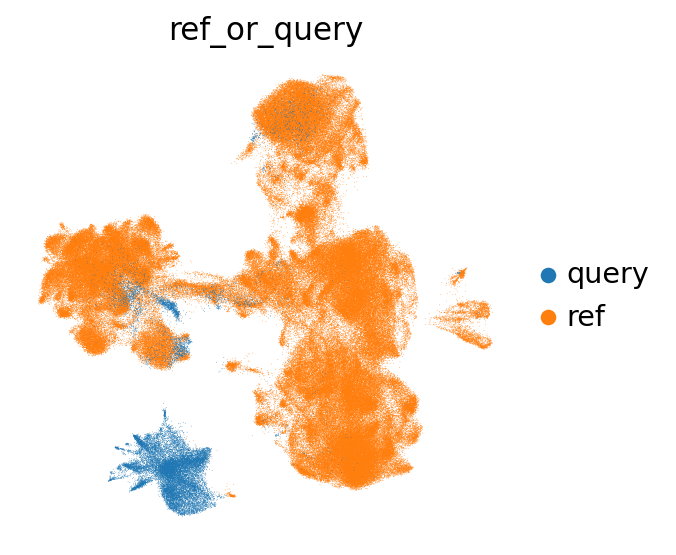

In [76]:
sc.pl.umap(combined_emb, color="ref_or_query", frameon=False, wspace=0.6)

Now let's take a look at the label transfer uncertainties per level. Regions with high uncertainty can highlight interesting cell types/states, not present in the reference. Note that uncertainties will get higher, the more detailed we go. Note that as we only used very few cells in the query here, they are more difficult to see in the joint embedding.

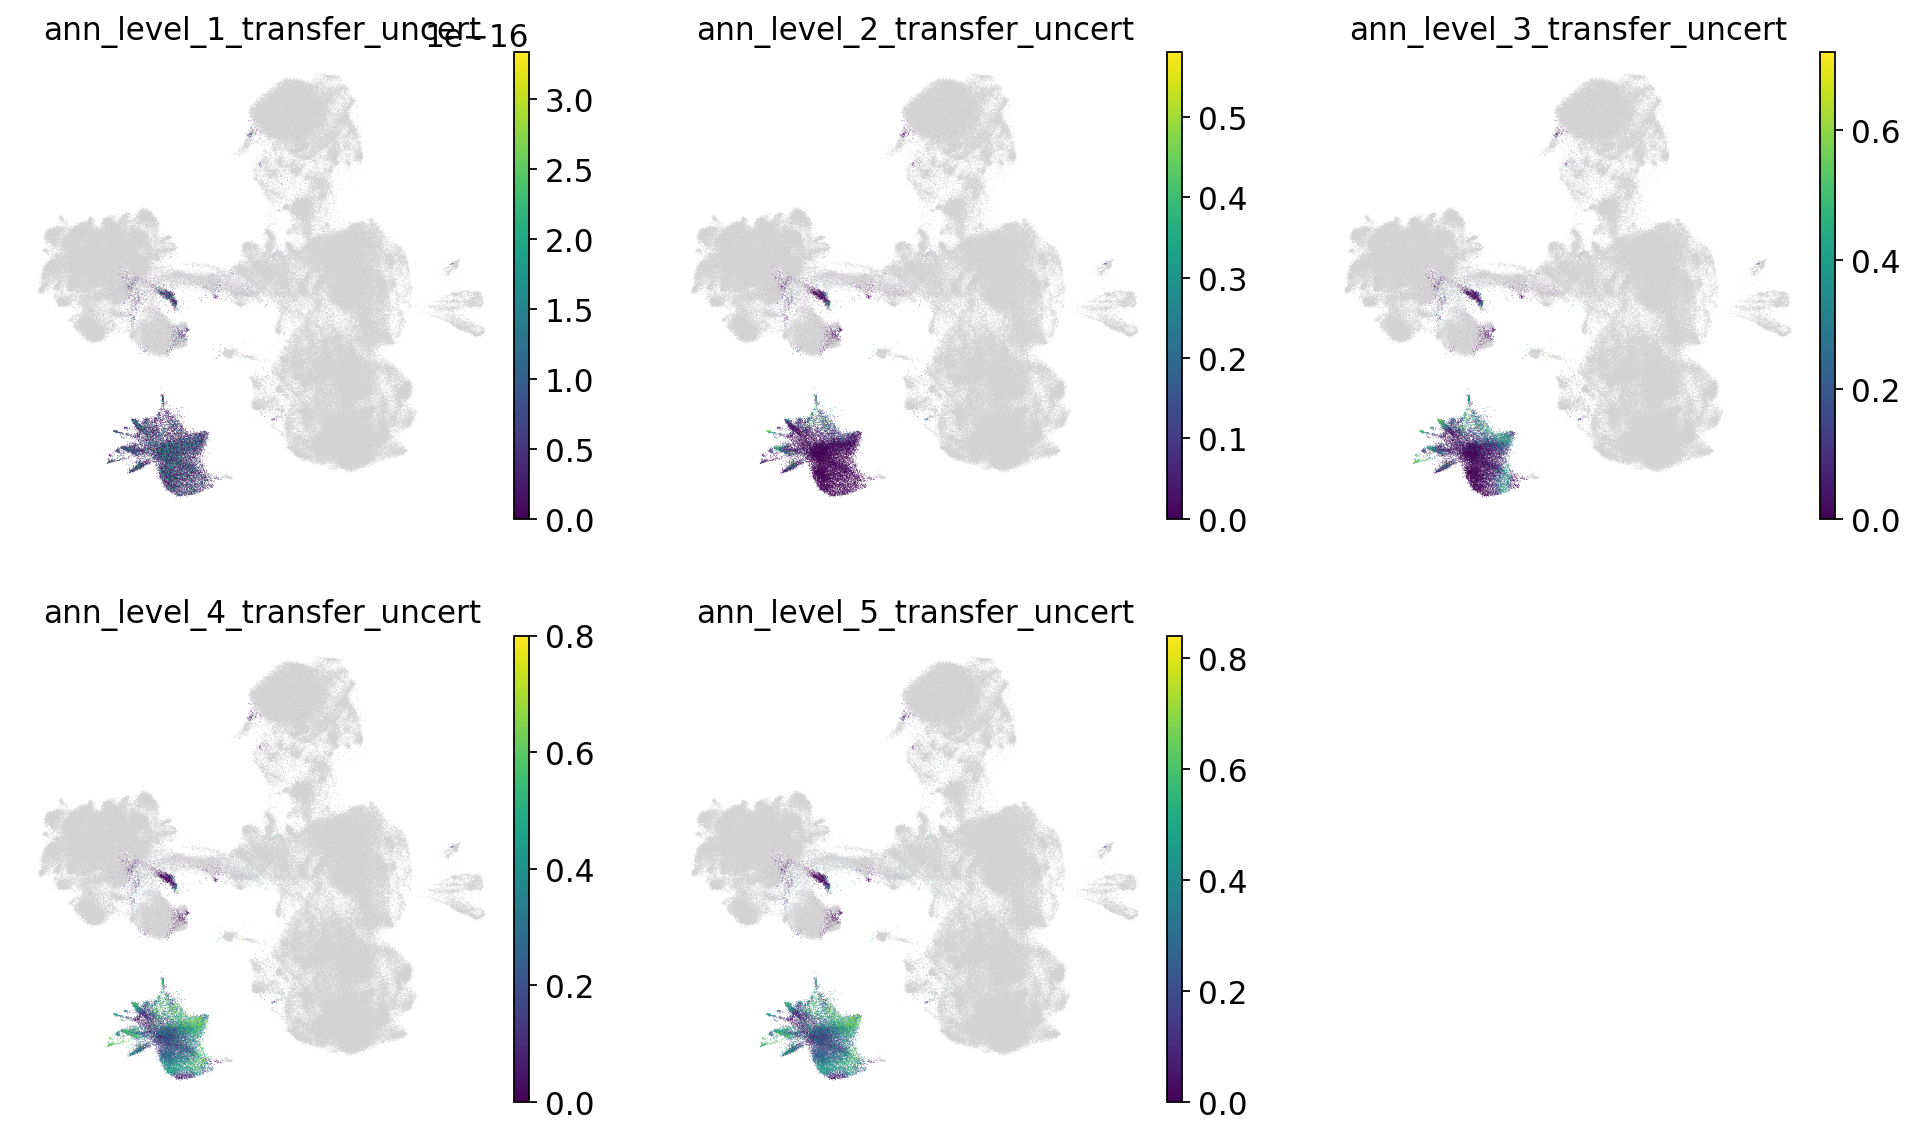

In [77]:
sc.pl.umap(
    combined_emb,
    color=[f"ann_level_{lev}_transfer_uncert" for lev in range(1, 6)],
    ncols=3,
    frameon=False,
)

Now let's take a look at the transferred labels, at every level. Note that the color for "Unknown" switches per plot, and that all cells from the reference are set to NA.

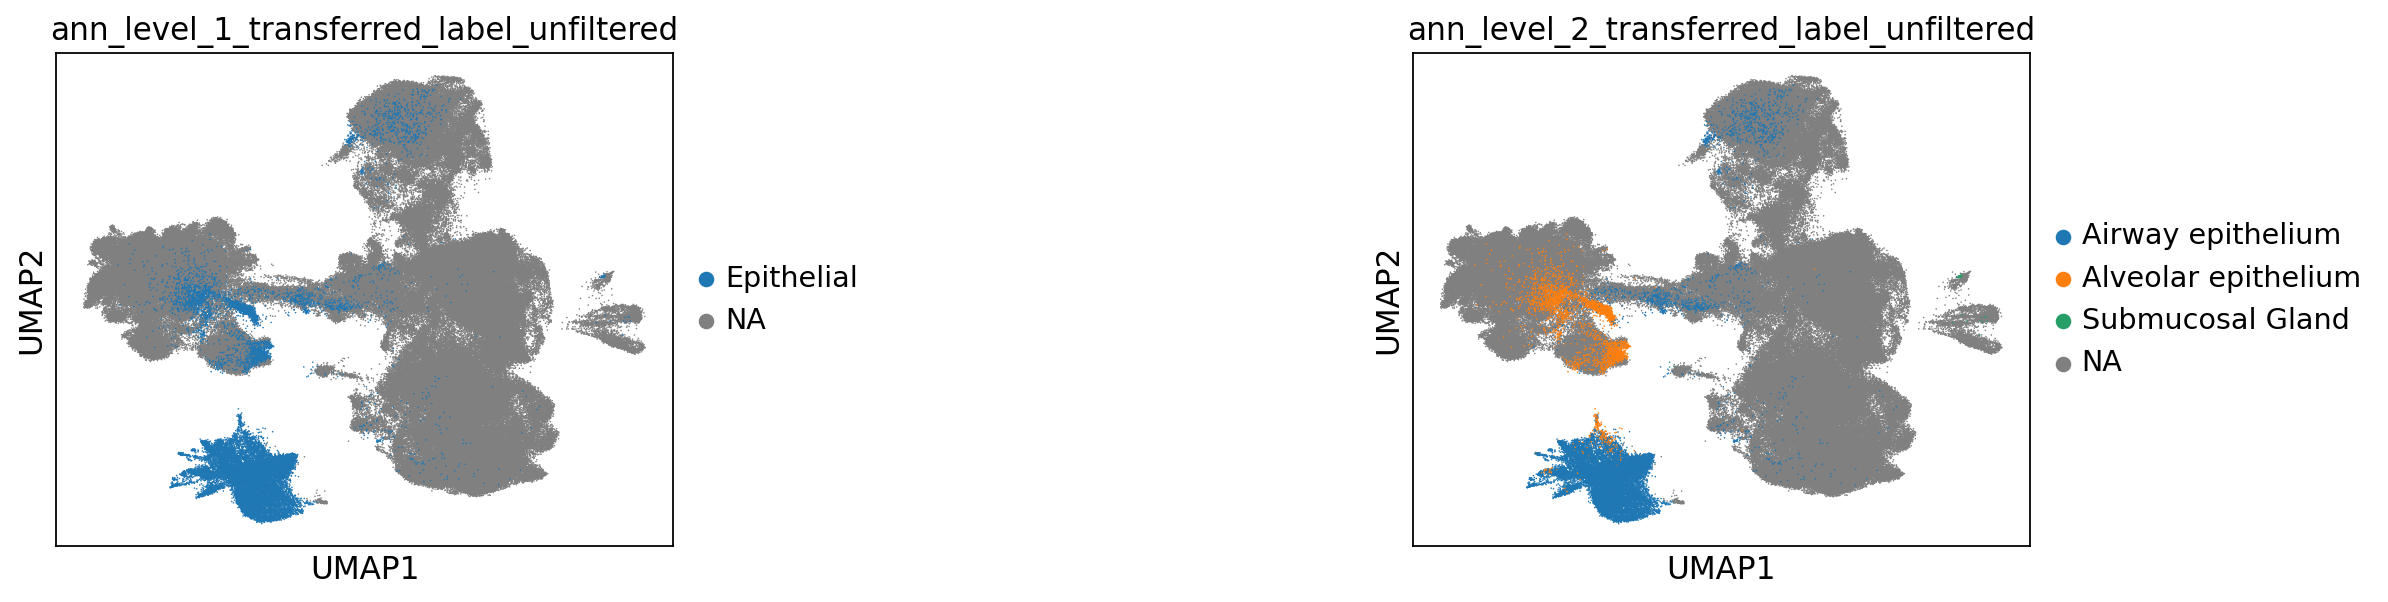

In [78]:
sc.pl.umap(
    combined_emb,
    color=[f"ann_level_{lev}_transferred_label_unfiltered" for lev in range(1, 3)],
    na_color="grey",
    ncols=2,
    size=2,
    wspace=1,
)

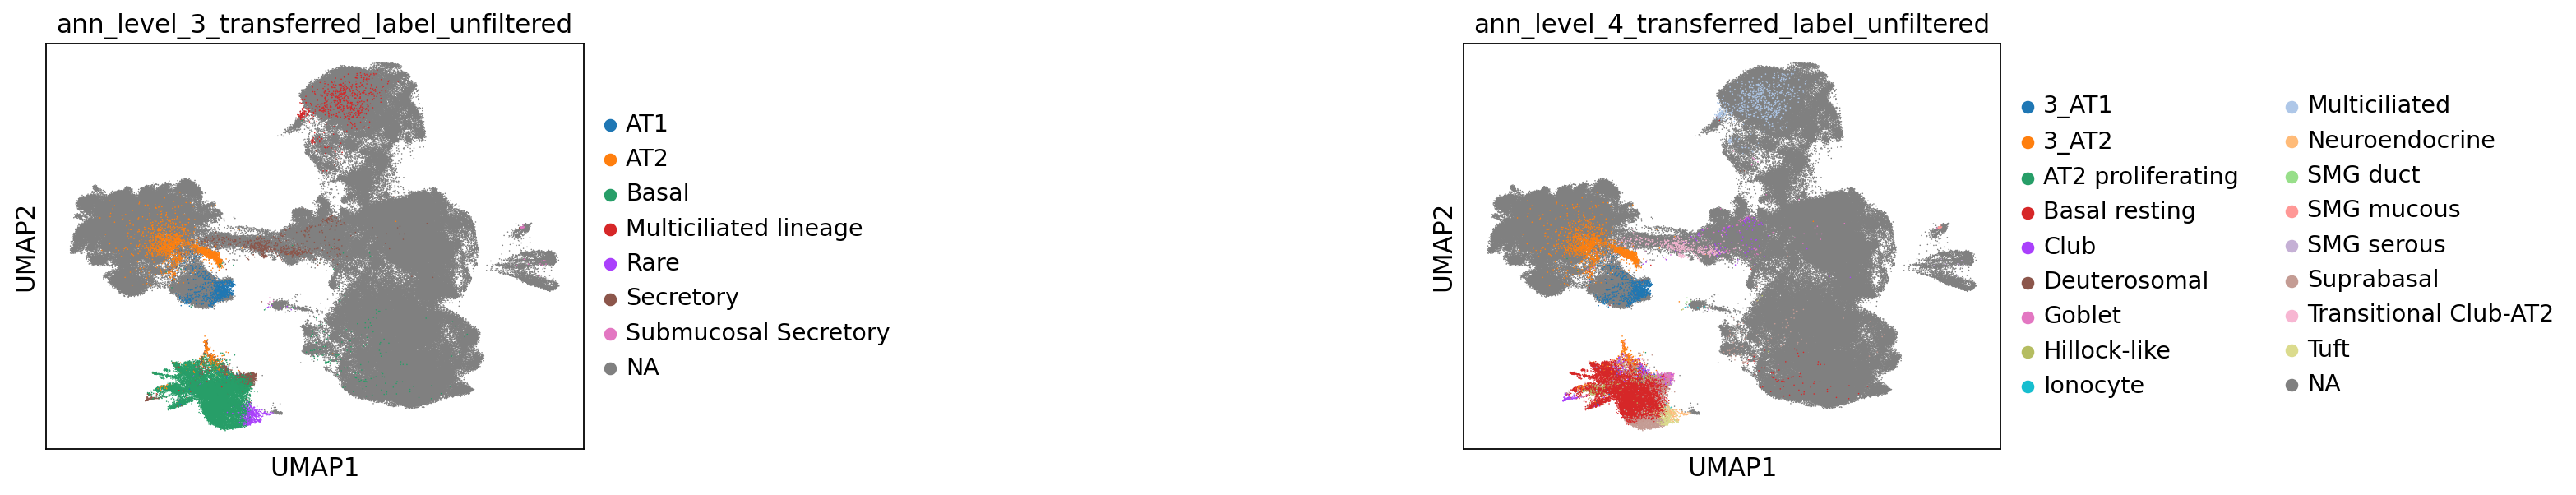

In [79]:
sc.pl.umap(
    combined_emb,
    color=[f"ann_level_{lev}_transferred_label_unfiltered" for lev in range(3, 5)],
    na_color="grey",
    ncols=2,
    size=2,
    wspace=1.4,
)

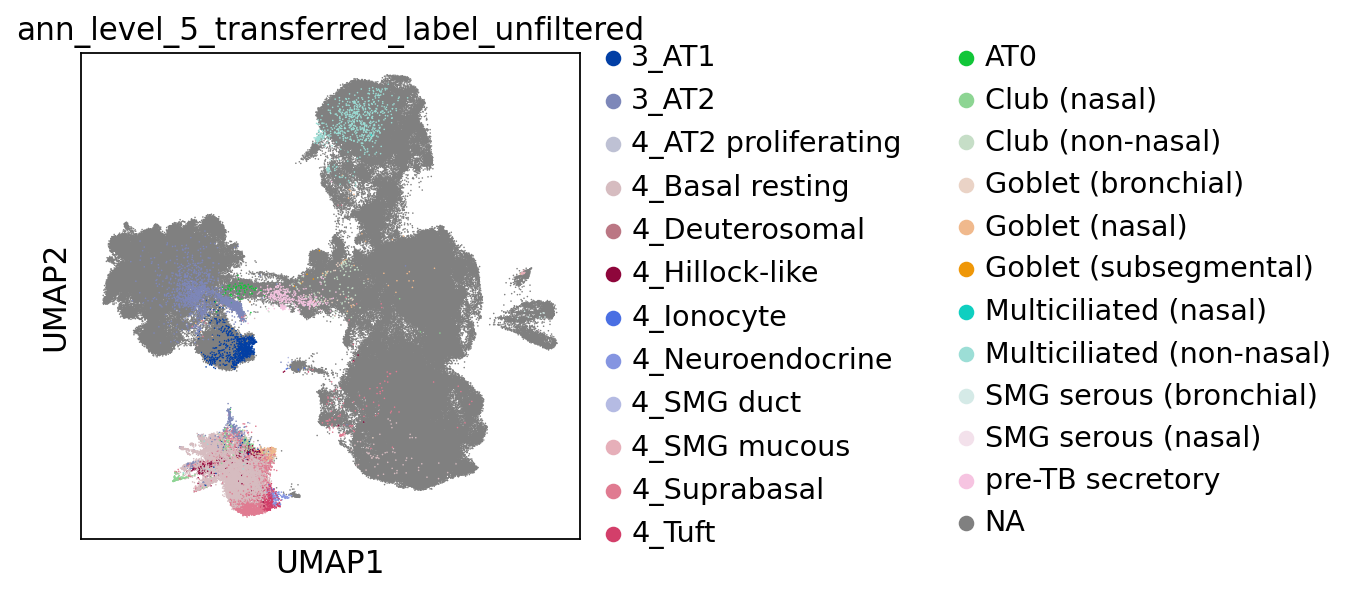

In [80]:
sc.pl.umap(
    combined_emb,
    color=[f"ann_level_5_transferred_label_unfiltered"],
    na_color="grey",
    size=2,
)

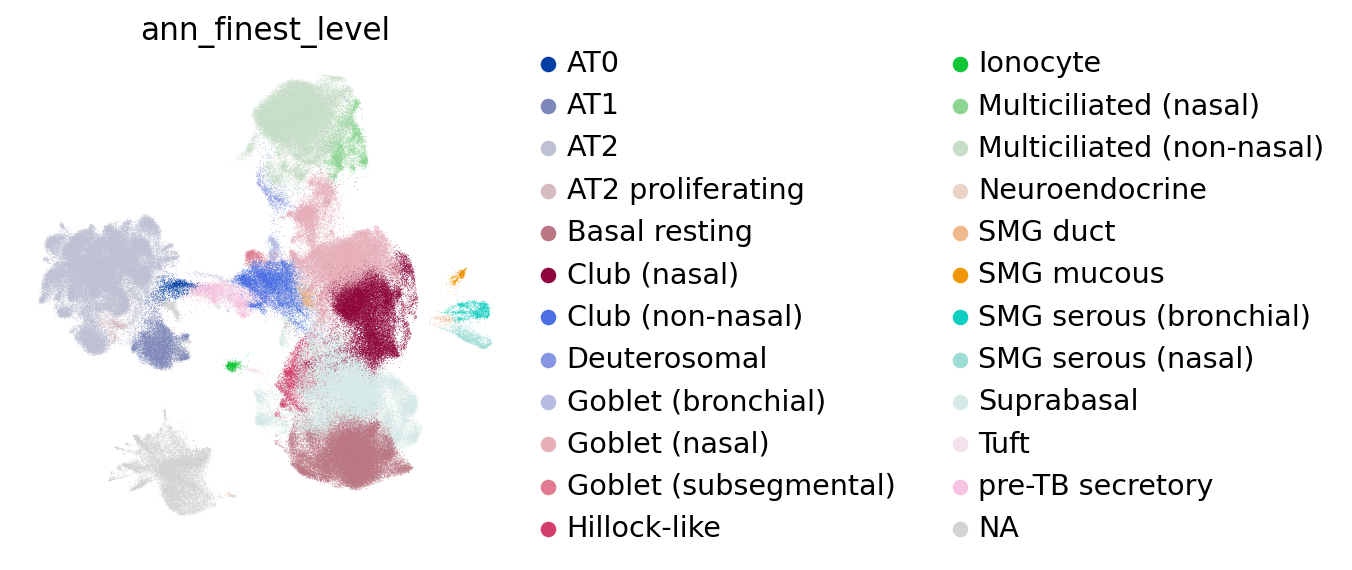

In [81]:
sc.pl.umap(combined_emb, color="ann_finest_level", frameon=False, wspace=0.6)

Visualization of the query alone, using reference-based embedding and including original gene expression values:

In [82]:
adata_query_final = (
    adata_query_unprep.copy()
)  # copy the original query adata, including gene counts

In [83]:
adata_query_final.obsm["X_scarches_emb"] = adata_query_latent[
    adata_query_final.obs.index, :
].X  # copy over scArches/reference-based embedding

If your original query_adata has gene ids instead of gene symbols as var.index, switch that here for easier gene querying. Adapt column names where necessary.

In [84]:
adata_query_final.var["gene_ids"] = adata_query_final.var.index
adata_query_final.var.index = adata_query_final.var.gene_names
adata_query_final.var.index.name = None

normalize gene counts and log transform (we'll do a simple total counts normalization here for simplicity):

In [85]:
sc.pp.normalize_per_cell(adata_query_final, counts_per_cell_after=10000)
sc.pp.log1p(adata_query_final)

copy over label transfer columns:

In [86]:
for col in combined_emb.obs.columns:
    if col.startswith("ann_level") and "transfer" in col:
        adata_query_final.obs[col] = combined_emb.obs.loc[
            adata_query_final.obs.index, col
        ]

calculate neigbhor graph based on scArches embedding, and generate UMAP:

In [87]:
sc.pp.neighbors(adata_query_final, use_rep="X_scarches_emb")
sc.tl.umap(adata_query_final)

Visualize label transfer details for a level of choice:

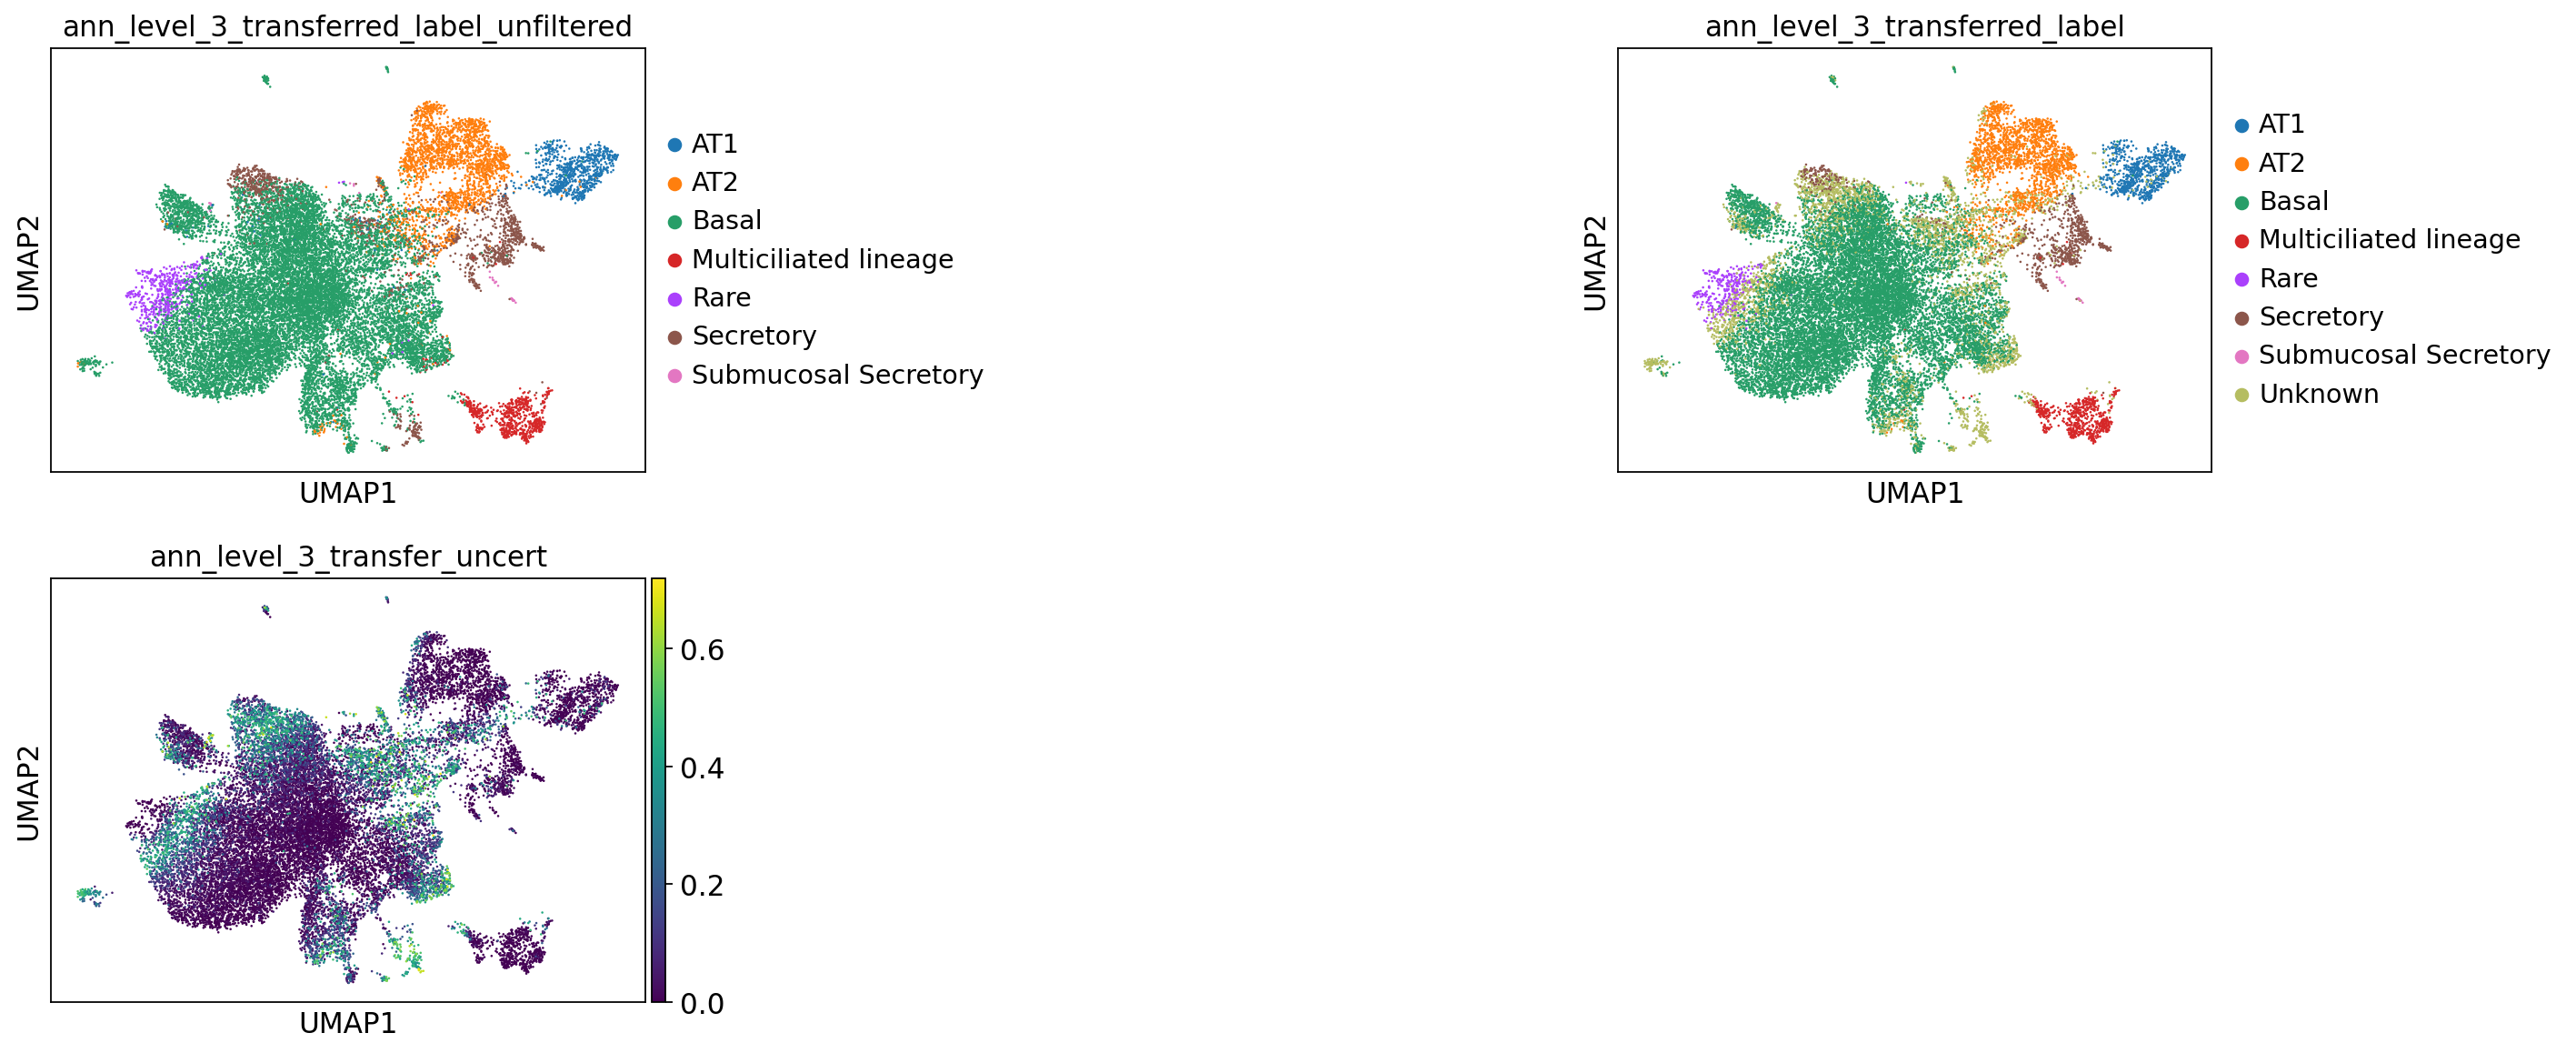

In [88]:
lev = 3
sc.pl.umap(
    adata_query_final,
    color=[
        f"ann_level_{lev}_transferred_label_unfiltered",
        f"ann_level_{lev}_transferred_label",
        f"ann_level_{lev}_transfer_uncert",
    ],
    wspace=1.4,
    ncols=2,
)

Now visualize gene expression of any genes of your interest:

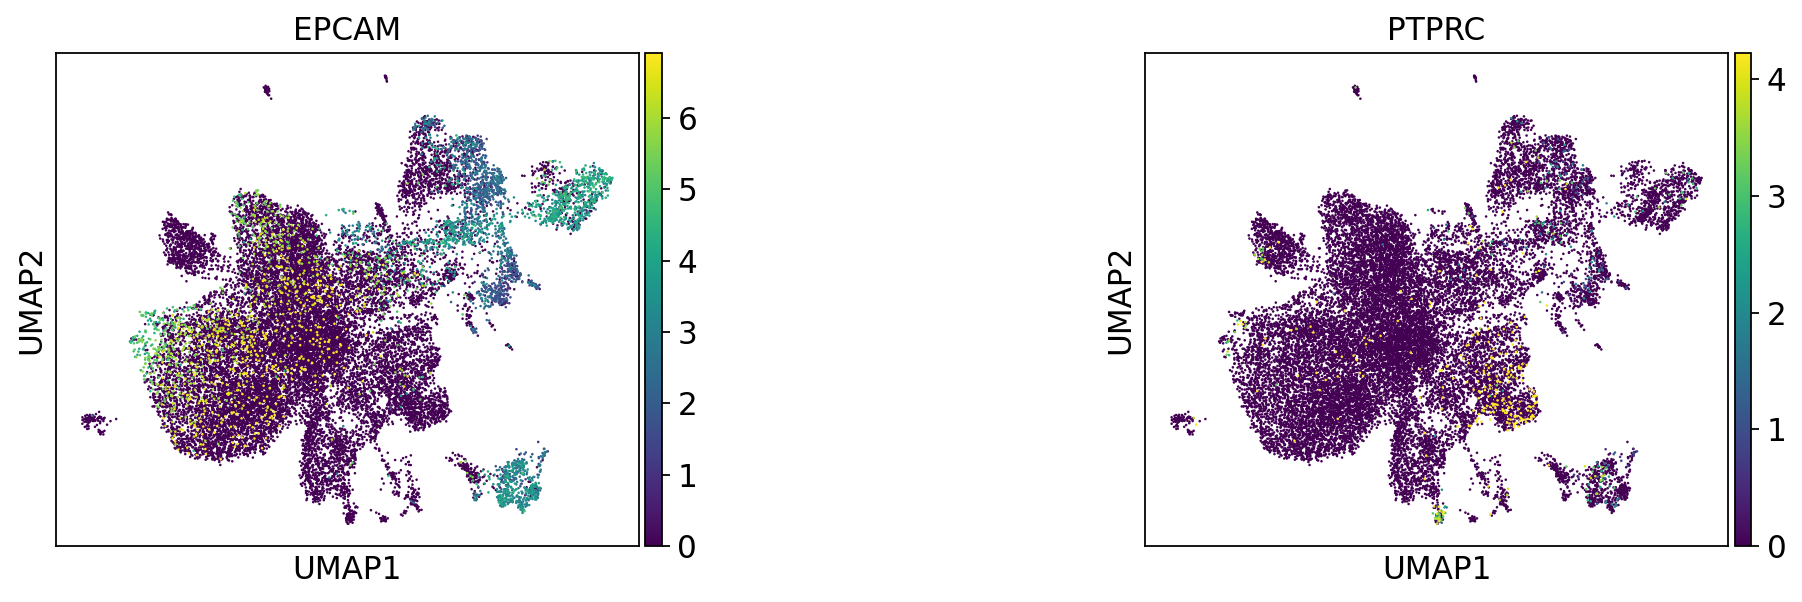

In [89]:
sc.pl.umap(
    adata_query_final,
    color=["EPCAM","PTPRC"],
    vmax="p99",
    wspace=0.7,
    ncols=2,
)

In [90]:
adata_query_final

AnnData object with n_obs × n_vars = 22551 × 1901
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'mnn_clusters', 'seurat_clusters', 'coarse_annotation', 'tumorstatus', 'ident', 'n_counts', 'ann_level_1_transferred_label_unfiltered', 'ann_level_2_transferred_label_unfiltered', 'ann_level_3_transferred_label_unfiltered', 'ann_level_4_transferred_label_unfiltered', 'ann_level_5_transferred_label_unfiltered', 'ann_level_1_transfer_uncert', 'ann_level_2_transfer_uncert', 'ann_level_3_transfer_uncert', 'ann_level_4_transfer_uncert', 'ann_level_5_transfer_uncert', 'ann_level_1_transferred_label', 'ann_level_2_transferred_label', 'ann_level_3_transferred_label', 'ann_level_4_transferred_label', 'ann_level_5_transferred_label'
    var: 'gene_names', 'gene_ids'
    uns: 'log1p', 'neighbors', 'umap', 'ann_level_3_transferred_label_unfiltered_colors', 'ann_level_3_transferred_label_colors'
    obsm: 'X_scarches_emb', 'X_umap'
    obsp: 'distances', 'connectivities'

In [91]:
adata_query_final.obs['ann_level_3_transferred_label'].value_counts()

ann_level_3_transferred_label
Basal                    14572
Unknown                   3473
AT2                       1917
Secretory                  843
AT1                        777
Multiciliated lineage      642
Rare                       303
Submucosal Secretory        24
Name: count, dtype: int64

In [92]:
adata_query_final.obs.to_csv('output_obs_normal.txt', sep='\t', header=True, index=True)

In [93]:
combined_emb.obs.to_csv('output_obs_normal_combined.txt', sep='\t', header=True, index=True)